# Bluebook for Bulldozers

## Preprocessing and Training

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA # not yet using
from sklearn.preprocessing import scale # not yet using
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from tpot import TPOTRegressor
from sklearn import preprocessing

In [2]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.2.2.


In [3]:
df = pd.read_csv(
    '../data/processed/exploratory-data-analysis.csv',
    low_memory=False
)

### Converting strings into categories

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372915 entries, 0 to 372914
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   372915 non-null  int64  
 1   SalePrice                 372915 non-null  float64
 2   MachineID                 372915 non-null  int64  
 3   ModelID                   372915 non-null  int64  
 4   datasource                372915 non-null  int64  
 5   auctioneerID              355456 non-null  float64
 6   YearMade                  372915 non-null  int64  
 7   MachineHoursCurrentMeter  130277 non-null  float64
 8   UsageBand                 68017 non-null   object 
 9   fiModelDesc               372915 non-null  object 
 10  fiBaseModel               372915 non-null  object 
 11  fiSecondaryDesc           250059 non-null  object 
 12  fiModelSeries             49026 non-null   object 
 13  fiModelDescriptor         70124 non-null   o

In [5]:
#  find the columns that contain strings, and turn them into categories
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype("category").cat.as_ordered()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372915 entries, 0 to 372914
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   372915 non-null  int64   
 1   SalePrice                 372915 non-null  float64 
 2   MachineID                 372915 non-null  int64   
 3   ModelID                   372915 non-null  int64   
 4   datasource                372915 non-null  int64   
 5   auctioneerID              355456 non-null  float64 
 6   YearMade                  372915 non-null  int64   
 7   MachineHoursCurrentMeter  130277 non-null  float64 
 8   UsageBand                 68017 non-null   category
 9   fiModelDesc               372915 non-null  category
 10  fiBaseModel               372915 non-null  category
 11  fiSecondaryDesc           250059 non-null  category
 12  fiModelSeries             49026 non-null   category
 13  fiModelDescriptor         701

In [7]:
df.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

Great -- now the string types have been converted into categories

## Filling in missing values

### Fill numeric rows with median value

In [8]:
# Check which columns have null values
numeric_null_columns = []
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            numeric_null_columns.append(label)
numeric_null_columns

['auctioneerID', 'MachineHoursCurrentMeter']

In [9]:
df[numeric_null_columns].isna().sum()

auctioneerID                 17459
MachineHoursCurrentMeter    242638
dtype: int64

In [10]:
for column in numeric_null_columns:
    median = df[column].median()
    df[column].fillna(median, inplace=True)

In [11]:
df[numeric_null_columns].isna().sum()

auctioneerID                0
MachineHoursCurrentMeter    0
dtype: int64

Great -- these values have been successfully imputed!

### Fill in categorical values

In [12]:
# check for columns that are not numeric
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [13]:
# turn categorical values into numbers, and fill in missing
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        # add a binary column to indicate whether row had a missing value
        df[label + '_is_missing'] = pd.isnull(content)
        # turn categories into numbers, and add one becuase padans assigns NaNs a value of -1
        df[label] = pd.Categorical(content).codes + 1

In [14]:
pd.Categorical(df['Transmission']).codes

array([3, 0, 7, ..., 0, 0, 0], dtype=int8)

Great -- these values now have codes!

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372915 entries, 0 to 372914
Columns: 101 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(44), float64(3), int16(4), int64(10), int8(40)
memory usage: 69.7 MB


In [16]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc',
       ...
       'Undercarriage_Pad_Width_is_missing', 'Stick_Length_is_missing',
       'Thumb_is_missing', 'Pattern_Changer_is_missing',
       'Grouser_Type_is_missing', 'Backhoe_Mounting_is_missing',
       'Blade_Type_is_missing', 'Travel_Controls_is_missing',
       'Differential_Type_is_missing', 'Steering_Controls_is_missing'],
      dtype='object', length=101)

In [17]:
df.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 101, dtype: int64

Nice -- we now have zero missing values

### Split the data to train and validation sets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns='SalePrice'), 
    df.SalePrice,
    test_size=0.3, 
    stratify=None, # we may want to stratify imbalanced labels
    random_state=42
)

In [19]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((261040, 100), (261040,), (111875, 100), (111875,))

### Building an evaluation function
Since we will be testing many instances of many models, we should put together a `show_scores` function.

In [20]:
def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)
    scores = {
        "Training...MAE": mean_absolute_error(y_train, train_preds),
        "Test.......MAE": mean_absolute_error(y_test, val_preds),
        "Training...RMLSE": rmsle(y_train, train_preds),
        "Test.......RMLSE": rmsle(y_test, val_preds),
        "Training...R2": r2_score(y_train, train_preds),
        "Test.......R2": r2_score(y_test, val_preds),
    }
    return scores

### Naive model implementation
Let's set up a quick model, on a subset of our data, and test it against our `show_scores` function

In [21]:
model = RandomForestRegressor(
    n_jobs=-1,
    random_state=42,
    max_samples=10000 # for better performance, since this is a massive dataset, we can train on samples.
)

In [22]:
%%time
model.fit(X_train, y_train)

CPU times: user 40.4 s, sys: 626 ms, total: 41 s
Wall time: 4.05 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [23]:
show_scores(model)

{'Training...MAE': 5395.372446789763,
 'Test.......MAE': 5579.017371477095,
 'Training...RMLSE': 0.23642824378258032,
 'Test.......RMLSE': 0.24545416628170555,
 'Training...R2': 0.8753352313858191,
 'Test.......R2': 0.865301689053226}

### Model-driven EDA

In [24]:
def plot_features(columns, importances, n=20):
    # create a df contianing features, and correspoding importances
    df = (pd.DataFrame({
        "features": columns,
        "feature_importance": importances
    })
    .sort_values("feature_importance", ascending=False)
    .reset_index(drop=True))
    
    # plot this dataframe
    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importance'][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

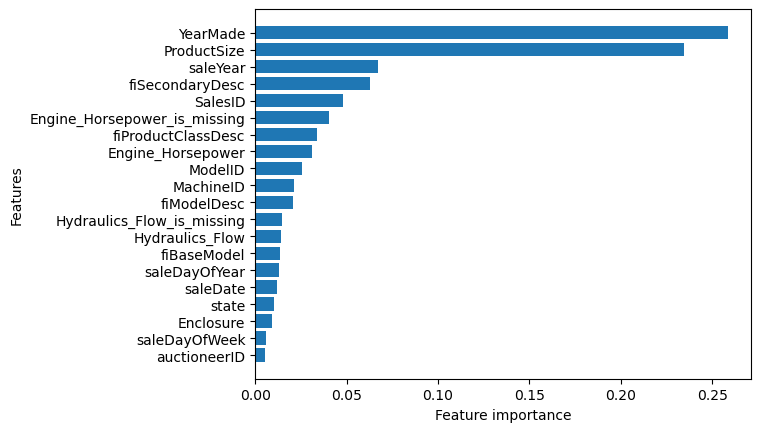

In [25]:
plot_features(X_train.columns, model.feature_importances_)

It looks like feature importance drops off pretty quickly.  Let's get a sense of which features account for 95% of importance.

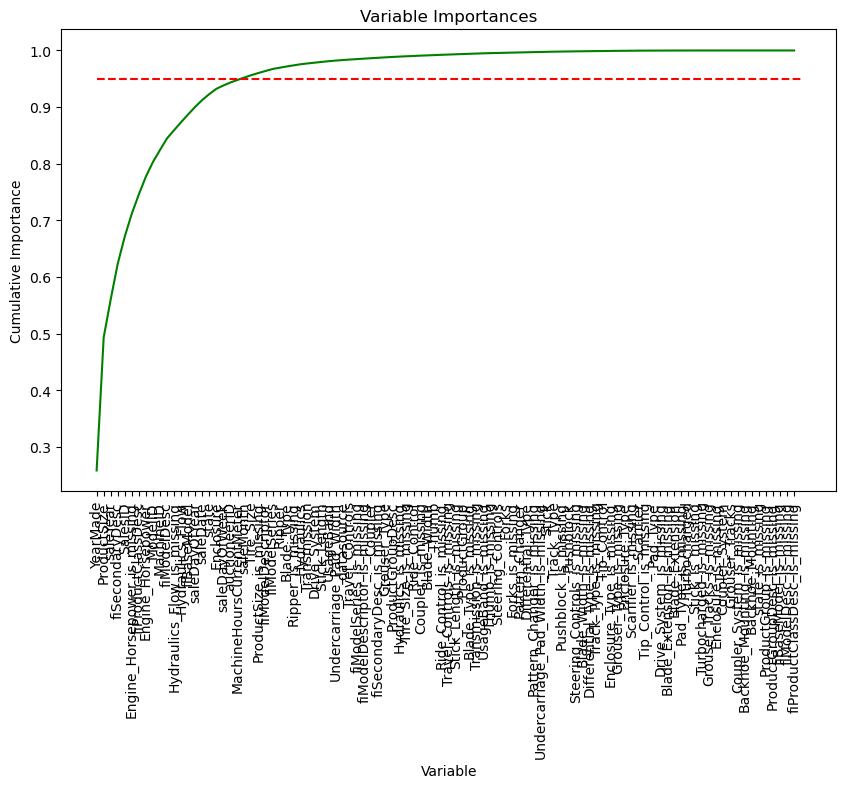

In [26]:
# Get feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Cumulative importances
cumulative_importances = np.cumsum(importances[indices])

# Make a line graph
plt.figure(figsize=(10, 6))
plt.plot(range(X_train.shape[1]), cumulative_importances, 'g-')
plt.hlines(y = 0.95, xmin=0, xmax=X_train.shape[1], color = 'r', linestyles = 'dashed')
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Variable Importances')

plt.show()

It looks like quite a few of these features are not included in that 95%.

Let's get a list of those features:

In [27]:
# Find index where cumulative importance exceeds 95%
# Add 1 because Python is zero-indexed
index_95 = np.where(cumulative_importances > 0.95)[0][0] + 1

# Get the names of unimportant features (those not contributing to 95% importance)
unimportant_feature_names = names[index_95:]

# Now unimportant_feature_names contains the names of the features that are not
# within the top 95% cumulative importance. You can print them out:
print("Features not contributing to 95% importance:")
for feature in unimportant_feature_names:
    print(feature)

Features not contributing to 95% importance:
Tire_Size
ProductSize_is_missing
fiModelDescriptor
fiModelSeries
Ripper
Blade_Type
Ripper_is_missing
Hydraulics
Transmission
Drive_System
Stick_Length
UsageBand
Undercarriage_Pad_Width
datasource
Travel_Controls
fiModelSeries_is_missing
fiModelDescriptor_is_missing
Coupler
fiSecondaryDesc_is_missing
Grouser_Type
ProductGroupDesc
Hydraulics_is_missing
Tire_Size_is_missing
Ride_Control
Coupler_is_missing
Blade_Width
Thumb
Ride_Control_is_missing
Travel_Controls_is_missing
Stick_Length_is_missing
ProductGroup
Blade_Type_is_missing
Transmission_is_missing
UsageBand_is_missing
Thumb_is_missing
Steering_Controls
Forks
Forks_is_missing
Pattern_Changer
Differential_Type
Pattern_Changer_is_missing
Undercarriage_Pad_Width_is_missing
Stick
Track_Type
Pushblock_is_missing
Pushblock
Steering_Controls_is_missing
Blade_Width_is_missing
Differential_Type_is_missing
Track_Type_is_missing
Tip_Control
Enclosure_Type_is_missing
Grouser_Type_is_missing
Enclosure

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372915 entries, 0 to 372914
Columns: 101 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(44), float64(3), int16(4), int64(10), int8(40)
memory usage: 69.7 MB


### Drop unimportant features

As fewer features means less computation, a tradeoff we should entertain is dropping the unimportant features so that we can have a more exhaustive gridsearch for hyperparameter tuning.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['SalePrice', *unimportant_feature_names]), 
    df.SalePrice,
    test_size=0.3, 
    random_state=42
)

## Hyperparameter tuning with RandomizedSearchCV

Let's do a preliminary cross-validation using Randomized Search CV, so we can get a sense of where the ideal parameters are.

In [30]:
# %%time
# param_grid = {
#     "n_estimators": np.arange(10, 100, 10),
#     "max_depth": [None, 3, 5, 10],
#     "min_samples_split": np.arange(2, 20, 2),
#     "min_samples_leaf": np.arange(1, 20, 2),
#     "max_features": [0.5, 1, 'sqrt', 'auto']
# }

# rs_model = RandomizedSearchCV(
#     RandomForestRegressor(
#         n_jobs=-1,
#         random_state=42,
#         max_features=1.0
#     ),
#     param_distributions=param_grid,
#     scoring='neg_mean_absolute_error',
#     n_iter=4, # increase for greater accuracy
#     cv=5,
#     verbose=True
# )

# rs_model.fit(X_train, y_train)

In [31]:
# show_scores(rs_model)

In [32]:
# rs_model.best_params_

## Hyperparameter tuning with GridSearchCV

In [33]:
# %%time
# param_grid = {
#     "n_estimators": np.arange(18, 22, 1),
#     "max_depth": [None],
#     "min_samples_split": np.arange(16, 21, 1),
#     "min_samples_leaf": np.arange(7, 11, 1),
#     "max_features": np.arange(0.25, 1, 0.25)
# }

# gs_model = GridSearchCV(
#     RandomForestRegressor(
#         n_jobs=-1,
#         random_state=42,
#     ),
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',
#     cv=5,
#     verbose=True
# )

# gs_model.fit(X_train, y_train)

In [34]:
# show_scores(gs_model)

In [35]:
# gs_model.best_params_

### Try using TPOT
http://epistasislab.github.io/tpot/

In [36]:
# # sample = df.sample(n=100000, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(
#     df.drop(columns=['SalePrice', *unimportant_feature_names]), 
#     df.SalePrice,
#     test_size=0.3, 
#     stratify=None, # we may want to stratify imbalanced labels
#     random_state=42
# )

In [37]:
# pipeline_optimizer = TPOTRegressor()

In [38]:
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

In [39]:
# pipeline_optimizer = TPOTRegressor(
#     scoring='neg_mean_absolute_error',
#     n_jobs=-1,
#     cv=cv,
#     random_state=42,    
#     generations=5,
#     population_size=50,
#     verbosity=2
# )

In [40]:
# %time
# pipeline_optimizer.fit(
#     X_train,
#     y_train
# )

best score so far: -5102

In [41]:
# pipeline_optimizer.export('../models/tpot_regressor.py')

### Try using streamlit
https://streamlit.io/